In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout du chemin vers les scripts sources
sys.path.append('..')

from src.clustering_utils import compare_clustering_methods
from src.viz_utils import plot_clustering_comparison, plot_projections
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuration esthétique
%matplotlib inline
sns.set_theme(style="whitegrid")

### 1. Chargement des données

In [2]:
# Chargement de la matrice d'embeddings (1506, 2048)
features = np.load("../data/processed/features_resnet.npy")

# Chargement du metadata.csv
df = pd.read_csv("../data/metadata.csv")

print(f"✅ Features chargées : {features.shape}")
print(f"✅ Métadonnées chargées : {len(df)} lignes")

✅ Features chargées : (1506, 2048)
✅ Métadonnées chargées : 1506 lignes


### 2. Standardisation des features

In [3]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f"Moyenne après scaling : {features_scaled.mean():.2f}")
print(f"Écart-type après scaling : {features_scaled.std():.2f}")

Moyenne après scaling : -0.00
Écart-type après scaling : 1.00


### 3. Réduction de Dimension (PCA & t-SNE)

Dimensions réduites par PCA : 257
Dimensions pour visualisation : (1506, 2)


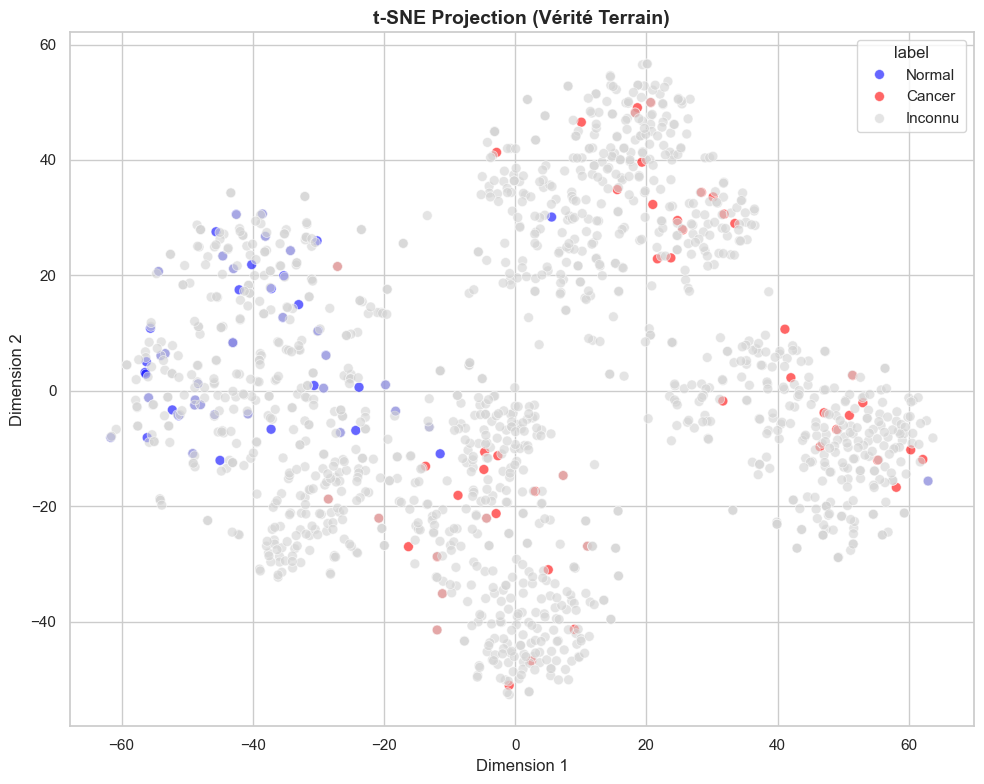

In [4]:
# 1. PCA pour le clustering (on garde 95% de la variance)
pca = PCA(n_components=0.95, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# 2. t-SNE pour la visualisation 2D
tsne = TSNE(
    n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto"
)
projections = tsne.fit_transform(features_pca)

print(f"Dimensions réduites par PCA : {features_pca.shape[1]}")
print(f"Dimensions pour visualisation : {projections.shape}")

# 3. Visualisation de la projection t-SNE

true_labels = df["label"].replace({-1: "Inconnu", 0: "Normal", 1: "Cancer"})
palette = {"Inconnu": "lightgrey", "Normal": "blue", "Cancer": "red"}

plot_projections(projections, true_labels, title="t-SNE Projection (Vérité Terrain)", palette=palette)

### 4. Compétition des algorithmes

In [5]:
# Appel de la fonction de comparaison créée dans src/clustering_utils.py
labels_dict, scores_dict = compare_clustering_methods(features_pca, df)

# Affichage des scores ARI
print("--- Scores ARI (Comparaison avec les 100 labels réels) ---")
for model, score in scores_dict.items():
    print(f"Targeting Accuracy ({model}) : {score:.4f}")

--- Scores ARI (Comparaison avec les 100 labels réels) ---
Targeting Accuracy (K-Means) : 0.4302
Targeting Accuracy (GMM) : 0.4302
Targeting Accuracy (Agglomératif) : 0.5137


### 5. Visualisation Comparative

In [ ]:
# Appel de la fonction de visualisation créée dans src/viz_utils.py
plot_clustering_comparison(projections, df, labels_dict, scores_dict)

In [ ]:
# Sélection du meilleur (à ajuster selon tes résultats)
best_model = "Agglomératif"

# On ajoute les labels faibles au DataFrame
df["weak_label"] = labels_dict[best_model]

# On crée une colonne combinée : label réel si présent, sinon label faible
df["final_label"] = df["label"].where(df["label"] != -1, df["weak_label"])

# Sauvegarde du nouveau fichier de travail
output_path = "../data/metadata_with_weak_labels.csv"
df.to_csv(output_path, index=False)

print(f"💾 Fichier sauvegardé avec succès : {output_path}")